In [1]:
from helper import *

/home/hongshel/miniconda3/envs/nt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-21 14:06:29.462232: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 14:06:29.513252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742580389.569828 3348527 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742580389.586977 3348527 cuda_blas.cc:140

## Pretrained Model

In [ ]:
device = get_device(gpu_id=0)  # Specify GPU ID
model_name = "baseline"
pretrained_model_name = "InstaDeepAI/nucleotide-transformer-500m-human-ref"
num_labels = 2
batch_size = 8

model = load_model(pretrained_model_name, num_labels, device)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

dataset_name = "promoter_all"
train_dataset = load_data(dataset_name, "train")
test_dataset = load_data(dataset_name, "test")

tokenized_train, tokenized_validation = preprocess_train_data(train_dataset, tokenizer)
tokenized_test, test_labels = preprocess_test_data(test_dataset, tokenizer)
training_args = get_training_args(model_name, batch_size)

trainer = train_model(model, training_args, tokenized_train, tokenized_validation, tokenizer)
save_model(trainer, model_name)
evaluate_model(trainer, tokenized_test, test_labels, model_name)
plot_f1_score(trainer, model_name)

IndentationError: unexpected indent (4037589834.py, line 2)

## Masked Inference

In [2]:
device = get_device(gpu_id=0)  # Specify GPU ID
model_name = "baseline"
num_labels = 2
pretrained_model_name = "InstaDeepAI/nucleotide-transformer-500m-human-ref"
batch_size = 8

# Load the saved model and tokenizer from the saved directory
model, tokenizer = load_saved_model(model_name, device)

# Load the dataset (both train and test are loaded to use the same preprocessing function)
dataset_name = "promoter_all"
# train_dataset = load_data(dataset_name, "train")
test_dataset = load_data(dataset_name, "test")

# Preprocess the datasets to obtain tokenized_test and test_labels
tokenized_test, test_labels = preprocess_test_data(test_dataset, tokenizer)

# Get the training arguments (needed to instantiate the Trainer)
training_args = get_training_args(model_name, batch_size)


Map: 100%|██████████| 5920/5920 [00:05<00:00, 1080.35 examples/s]
/home/hongshel/miniconda3/envs/nt/lib/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
def evaluate_model(trainer, tokenized_test, test_labels, model_name: str):
    print(len(tokenized_test))
    test_results = trainer.predict(tokenized_test)
    print(len(test_results.predictions))
    predictions = np.argmax(test_results.predictions, axis=-1)
    print(len(predictions))
    cm = confusion_matrix(test_labels, predictions)
    
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix on Test Set - {model_name}")
    plt.savefig(f"confusion_matrix_{model_name}.png")
    plt.show()

    print("Test Metrics:")
    print(f"F1 Score: {test_results.metrics.get('test_f1_score', 'N/A')}")
    print(f"MCC: {matthews_corrcoef(test_labels, predictions)}")

/tmp/ipykernel_3348527/3667881479.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/hongshel/miniconda3/envs/nt/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


5920
5920


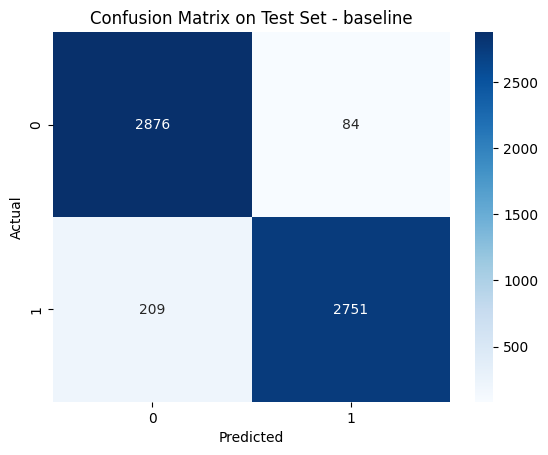

Test Metrics:
F1 Score: 0.9494391716997411
MCC: 0.9018180009431723


In [3]:

# Create a Trainer instance using the loaded model and tokenizer
from transformers import Trainer  # Ensure Trainer is imported if not already
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    eval_dataset=tokenized_test,
)

# Evaluate the model using the test set and print out the metrics and confusion matrix
evaluate_model(trainer, tokenized_test, test_labels, model_name)

Map: 100%|██████████| 5920/5920 [00:01<00:00, 3028.27 examples/s]
/home/hongshel/miniconda3/envs/nt/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


5920


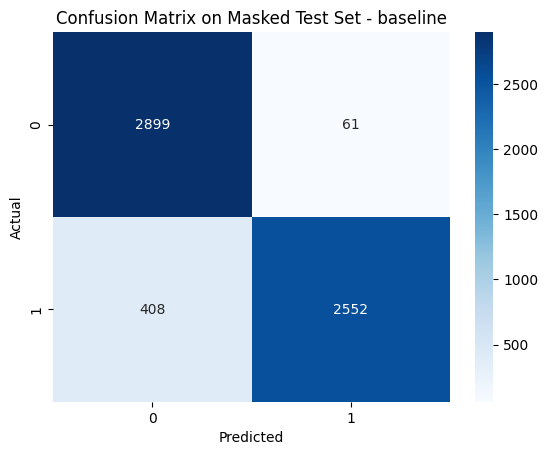

Test Metrics (Masked Inference):
F1 Score: 0.915844249057958
MCC: 0.847397005972165


In [7]:
evaluate_model_masked(trainer, tokenized_test, test_labels, model_name, tokenizer, mask_ratio=0.1)

Map: 100%|██████████| 5920/5920 [00:02<00:00, 2945.71 examples/s]
/home/hongshel/miniconda3/envs/nt/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


5920


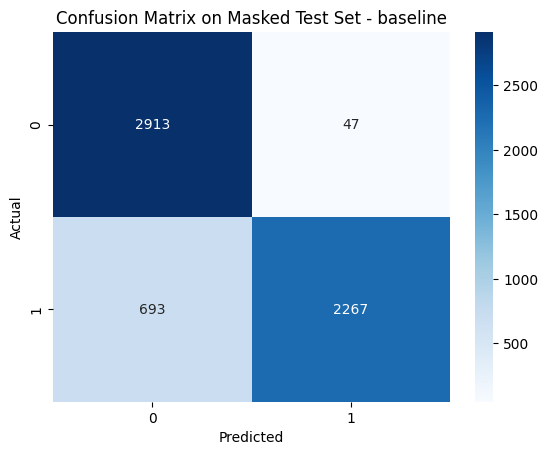

Test Metrics (Masked Inference):
F1 Score: 0.8596890405764126
MCC: 0.7685257721652212


In [4]:
evaluate_model_masked(trainer, tokenized_test, test_labels, model_name, tokenizer, mask_ratio=0.2)

Map: 100%|██████████| 5920/5920 [00:02<00:00, 2163.05 examples/s]
/home/hongshel/miniconda3/envs/nt/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


5920


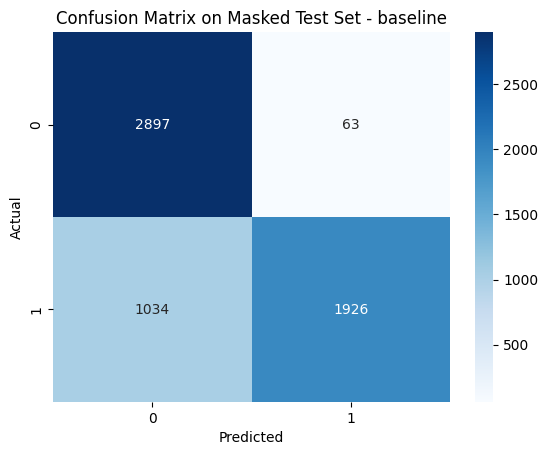

Test Metrics (Masked Inference):
F1 Score: 0.7783390583956354
MCC: 0.6662603082769287


In [6]:
evaluate_model_masked(trainer, tokenized_test, test_labels, model_name, tokenizer, mask_ratio=0.3)

Map: 100%|██████████| 5920/5920 [00:01<00:00, 2999.57 examples/s]
/home/hongshel/miniconda3/envs/nt/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


5920


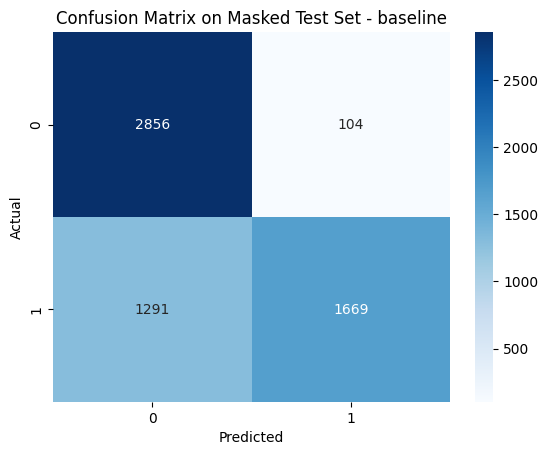

Test Metrics (Masked Inference):
F1 Score: 0.7052609338685822
MCC: 0.5771556565220252


In [8]:
evaluate_model_masked(trainer, tokenized_test, test_labels, model_name, tokenizer, mask_ratio=0.4)

Map: 100%|██████████| 5920/5920 [00:02<00:00, 2898.20 examples/s]
/home/hongshel/miniconda3/envs/nt/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


5920


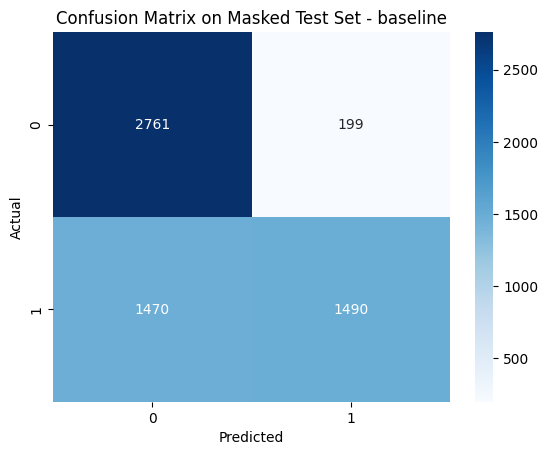

Test Metrics (Masked Inference):
F1 Score: 0.6409980640998064
MCC: 0.4829363604480351


In [5]:
evaluate_model_masked(trainer, tokenized_test, test_labels, model_name, tokenizer, mask_ratio=0.5)